# Assignment 2

> Group Members: Julius Kappenberg, Alexandros Gilch, Paul Grass, Tim Mensinger, Philipp Schirmer

## Question II: Fiscal Policy

This notebook is structured as follows: First I define functions that implement the local projection method, the plotting of the resulting impulse response functions and the data preparation step. This section can be skipped. Aferwards we answer question *i.* Then we apply the local projection method on our data and plot the impulse response functions. At last we summarize our findings and answer question *iii.*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import scipy as sp

sns.set_style("whitegrid")

## Code

#### Local Projection Method

In [2]:
def _create_formula_with_lags(var_name, n_lags):
    """Creates formula str of var_name with n_lags."""
    covariates = [f"{var_name}.shift({i})" for i in range(1, n_lags + 1)]
    formula = " + ".join(covariates)
    return formula


def _create_formula_to_extract_shocks(endog, exog, n_lags):
    """Creates callable formula str with lagged exog regressors."""
    exog_formulas = [_create_formula_with_lags(name, n_lags) for name in exog]
    formula = f"{endog} ~ 1 + " + " + ".join(exog_formulas)
    return formula


def local_projection(df, n_response_periods, n_lags, alpha):
    """Estimate impulse response using local projections.
    
    This function is not written in a general manner and this is
    on purpose. Sets of exogeneous and endogeneous variables are
    defined inside to avoid overly abstract code.
    
    Args:
        df (pandas.DataFrame): The data.
        n_response_periods (int): Number of response periods.
        n_lags (int): Number of lags to use in shock creation.
        alpha (float): Confidence level. Must be in [0, 1].
        
    Returns:
        Dict[pandas.DataFrame]: Dictionary containing
            impulse_response: The estimated impulse responses.
            df: The updated initial data frame.
    
    """
    exog = ["g_pc", "gdp_pc", "rev_pc"]
    exog_formulas = [_create_formula_with_lags(name, n_lags) for name in exog]
    exog_formula = " + ".join(exog_formulas)

    # estimate impulse responses
    impulse_response = pd.DataFrame(columns=["h", "endog", "estimate", "se"])
    impulse_response = impulse_response.set_index(["h", "endog"])

    for h in range(n_response_periods):
        for endog in df.columns:
            formula = f"{endog}.shift({-h-1}) ~ 1 + g_pc + " + exog_formula
            model = sm.ols(formula, df).fit(cov_type="HAC", cov_kwds={"maxlags": 1})
            theta = model.params["g_pc"]
            theta_se = model.bse["g_pc"]
            impulse_response.loc[(h + 1, endog), "estimate"] = theta
            impulse_response.loc[(h + 1, endog), "se"] = theta_se

    # result processing
    cf = sp.stats.norm.ppf(1 - alpha / 2)  # confidence factor
    impulse_response = impulse_response.reset_index().convert_dtypes()
    impulse_response.estimate *= -1
    impulse_response = impulse_response.assign(
        **{
            "lower_ci": impulse_response.estimate - cf * impulse_response.se,
            "upper_ci": impulse_response.estimate + cf * impulse_response.se,
        }
    )

    result = {"impulse_response": impulse_response, "df": df}
    return result

#### Impulse Response Plot

In [3]:
def plot_impulse_responses(result, df):
    """Plots all impulse responses."""
    fig, axes = plt.subplots(4, 2)
    fig.set_size_inches(17, 20)

    for ax, col in zip(axes.flatten(), df.columns):

        # subset data
        _data = (
            result["impulse_response"]
            .query("endog == @col")
            .drop(columns="endog")
            .astype(float)
        )

        # plot estimate
        p = sns.lineplot(x="h", y="estimate", data=_data, ax=ax, label=col)

        # plot standard errors
        ax.plot(_data["h"], _data["lower_ci"], alpha=0.3, color="tab:blue")
        ax.plot(_data["h"], _data["upper_ci"], alpha=0.3, color="tab:blue")
        ax.fill_between(
            _data["h"], _data["lower_ci"], _data["upper_ci"], alpha=0.2, color="tab:blue"
        )

        # adjust plot
        ax.axhline(0, color="black", alpha=0.85, zorder=-1)
        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
        ax.set(ylabel="IR", xlabel=r"$h$")
        ax.set_frame_on(False)
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        _ = ax.legend(frameon=False, fontsize=14)

#### Data Reading and Cleaning

In [4]:
def _log_transform(column, ignore=None):
    column = column.copy()
    ignore = ignore if isinstance(ignore, list) else [ignore]
    if column.name not in ignore:
        column = 100 * np.log(column)
    return column


def read_and_clean_data():
    """Read and prepare data."""
    df = pd.read_stata("data/fiscal_data1930s.dta")
    df = df.set_index("date")
    df = df.transform(_log_transform, ignore="irate")
    return df

In [5]:
df = read_and_clean_data()
df.head()

,gdp_pc,ip,g_pc,g_mil_pc,rev_pc,wpi,irate,unemp
date,,,,,,,,
1927-04-01,428.262029,462.281835,175.692230,117.088593,184.588394,490.379220,5.0,724.943359
1927-05-01,428.494448,464.662937,188.093063,126.212456,213.380951,492.071059,5.0,718.639221
1927-06-01,428.956984,463.184178,164.157944,75.750061,193.909149,492.652878,6.0,714.218323
1927-07-01,429.649906,468.730094,167.101929,89.459831,180.464691,492.435093,6.0,709.271973
1927-08-01,430.138579,468.647081,159.718750,59.362907,181.848373,492.652878,6.0,704.679688


## Results
 
#### i.
From the question description we recall
 
 > The identifying assumption is that public expenditures are predetermined within a given period (i.e., they do not react to shocks to other variables in the same time period).
 
The below histogram illustrates the time difference between consecutive periods in days. We see that the data contains monthly observations. One may argue that during the period of a month, shocks can occur to other variables to which the political process responds with a change in spending in the same period. However, since the political process is known to be slow, the assumption that such a response takes _at least a month_ does seem reasonable. Even in (economic) crises, bureaucracy may not allow for responses to be significantly faster than a month.

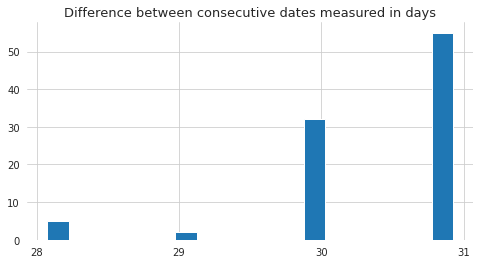

In [6]:
diff = np.diff(df.index).astype("timedelta64[D]")
diff = pd.Series(diff).dt.days

fig, ax = plt.subplots(1)
fig.set_size_inches(8, 4)
diff.hist(ax=ax, rwidth=0.5)
ax.set_frame_on(False)
ax.set_title("Difference between consecutive dates measured in days", size=13)
_ = ax.set_xticks(diff.unique())

### ii.

#### Implementation of Local Projection Method

#### Application of Local Projection Method

In [7]:
result = local_projection(df, n_response_periods=24, n_lags=6, alpha=0.05)

#### Plotting

The figure below shows the impulse response functions for all columns of the data set.

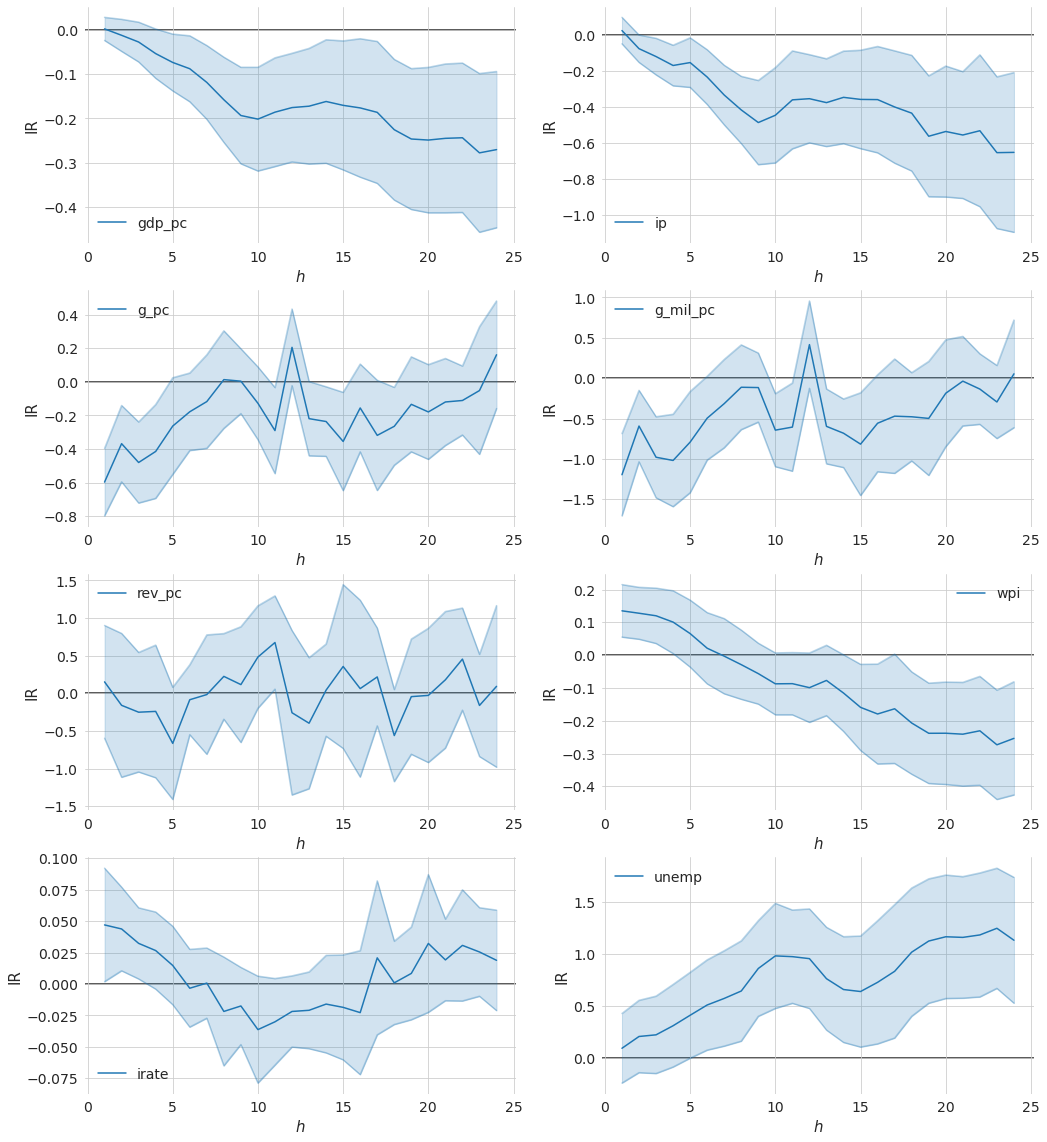

In [8]:
plot_impulse_responses(result, df)

### iii.

Our estimates show a negative effect of a decrease in government spendings on GDP. The effect manifests fully after 10 months and amounts to -0,2 to -0,25 percentage points. This supports the argument that Brüning’s austerity policy was detrimental for the German economy at the time. However, the estimate for the loss of GDP after a budget spending shock is too small to advocate for this policy to be a main reason for the output slump. Brüning’s policy contributed to the negative effect but could not have avoided it by increasing government spending.